In [1]:
# Load pyspark
import findspark

findspark.init()

from pyspark import SparkContext

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml import Pipeline

from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation

import pandas as pd
import numpy as np

# charting
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [2]:
df_train = spark.read.parquet("data/preprocessed")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1452, 32)


### Plot

In [3]:
from pyspark.sql.functions import min, max

df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(min("week_start_date"), max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(min("week_start_date"), max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (932, 32)
	date_start = 1990-05-28 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (520, 32)
	date_start = 2000-07-01 / date_stop = 2010-06-25


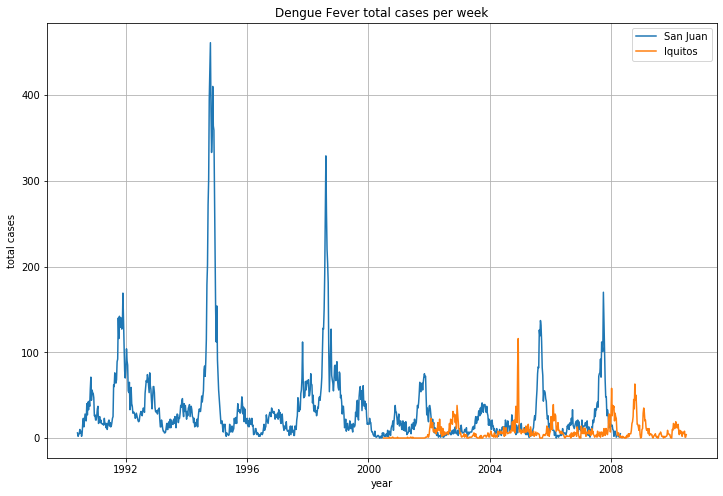

In [4]:
pd_train_sj = df_train_sj.toPandas()
pd_train_iq = df_train_iq.toPandas()

# Total cases per city
plt.figure(figsize=(12, 8))

plt.grid()
plt.title('Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.legend()

plt.show()

### Construction du *pipeline*

In [5]:
indexer = StringIndexer(inputCol='city', outputCol='city_')

encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

vectorAssembler = VectorAssembler(
    inputCols=['year', 'weekofyear',
               'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'reanalysis_air_temp_k','reanalysis_avg_temp_k',
               'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
               'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',
               'cityVect'], 
    outputCol = 'features')

scaler = StandardScaler(inputCol='features',
                        outputCol="scaled_features",
                        withStd=True, withMean=True)

lr = LinearRegression(featuresCol='scaled_features',
                      labelCol='total_cases',
                      predictionCol='lr_prediction')

rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

In [6]:
vectorAssembler2 = VectorAssembler(
    inputCols=['year', 'weekofyear',
               'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'reanalysis_air_temp_k','reanalysis_avg_temp_k',
               'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
               'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
               'station_avg_temp_c',
               'station_avg_temp_1_c', 'station_avg_temp_2_c', 'station_avg_temp_3_c', 'station_avg_temp_4_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',
               'station_precip_1_mm', 'station_precip_2_mm', 'station_precip_3_mm', 'station_precip_4_mm',
               'cityVect'], 
    outputCol = 'features')

### Construction des jeux d'entrainement et de test (random split)

In [7]:
# random split
train, test = df_train.randomSplit([0.90, 0.10], seed=18)

train.cache()

DataFrame[city: string, year: int, weekofyear: int, week_start_date: date, ndvi_ne: float, ndvi_nw: float, ndvi_se: float, ndvi_sw: float, reanalysis_air_temp_k: float, reanalysis_avg_temp_k: float, reanalysis_dew_point_temp_k: float, reanalysis_max_air_temp_k: float, reanalysis_min_air_temp_k: float, reanalysis_precip_amt_kg_per_m2: float, reanalysis_relative_humidity_percent: float, reanalysis_sat_precip_amt_mm: float, reanalysis_specific_humidity_g_per_kg: float, reanalysis_tdtr_k: float, station_avg_temp_c: float, station_diur_temp_rng_c: float, station_max_temp_c: float, station_min_temp_c: float, station_precip_mm: float, total_cases: int, station_avg_temp_1_c: float, station_avg_temp_2_c: float, station_avg_temp_3_c: float, station_avg_temp_4_c: float, station_precip_1_mm: float, station_precip_2_mm: float, station_precip_3_mm: float, station_precip_4_mm: float]

### 1. Linear regression

#### 1.1 Simple

In [ ]:
pipeline_lr = Pipeline(stages=[indexer, encoder, vectorAssembler2, scaler, lr])

evaluator_lr = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='lr_prediction',
                                   metricName="rmse")

model_lr = pipeline_lr.fit(train)

# Build prediction from 'test' dataset
pred_lr = model_lr.transform(test)

pred_lr.select(['total_cases','lr_prediction']).show(10)

rmse = evaluator_lr.evaluate(pred_lr)

print("Linear regression::Before grid search - RMSE = {:.3f}".format(rmse))

#### 1.2 Cross validation

In [ ]:
# Parameter grid for linear regression (LR)
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator_lr,
                             numFolds=2,
                             seed=18)

cv_model_lr = crossval_lr.fit(train)

# Build prediction from 'test' dataset
cv_pred_lr = cv_model_lr.transform(test)

rmse = evaluator_lr.evaluate(cv_pred_lr)

print("Linear regression::After grid search - RMSE = {:.3f}".format(rmse))

### 2. Random Forest

#### 2.1 Simple

In [8]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="rmse")

# build model
model_rf = pipeline_rf.fit(train)

# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

pred_rf.select(['total_cases','rf_prediction']).show(10)

rmse = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - RMSE = {:.3f}".format(rmse))

+-----------+------------------+
|total_cases|     rf_prediction|
+-----------+------------------+
|          0| 5.067016512004365|
|          1| 5.362895409933626|
|          0| 6.341539441558234|
|          0| 4.723200992180396|
|          1| 4.568442626062649|
|          0| 5.981023462498112|
|          0| 6.415448477690397|
|         18|10.534499182552608|
|          1| 9.123721491653392|
|          1| 7.253071149097158|
+-----------+------------------+
only showing top 10 rows

Random Forest::Before grid search - RMSE = 40.570


#### 2.2 Cross-Validation

In [9]:
# Parameter grid for random forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10, 15, 20]) \
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rf,
                             numFolds=2,
                             seed=18)

cv_model_rf = crossval_rf.fit(train)

# Build prediction from 'test' dataset
cv_pred_rf = cv_model_rf.transform(test)

rmse = evaluator_rf.evaluate(cv_pred_rf)

print("Random Forest::After grid search - RMSE = {:.3f}".format(rmse))

Random Forest::After grid search - RMSE = 28.680


In [ ]:
cv_model_rf.bestModel.stages[-1].getNumTrees

#### plot

In [ ]:
# create pandas dataframe from spark dataframe
pd_pred_rf = cv_pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

In [ ]:
# Total cases per city
plt.figure()

plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'], label='Pred: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'], label='Pred: Iquitos')

plt.legend()

plt.show()